!pip install spacy
!python -m spacy download en_core_web_sm
!pip install --user -U nltk

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import os

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import re

from datetime import datetime
from time import time

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, pairwise_distances
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import spacy

In [2]:
nltk.download('punkt') #tokenizer + stopwords for all lang.
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\Sukanya
[nltk_data]     Krishna\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Sukanya
[nltk_data]     Krishna\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Used this example code as a reference

https://github.com/Swathiu/Detecting-Fake-Reviews/blob/master/Deception_Detection.py


In [3]:
#making sure there is no dataset loaded

pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [4]:
df = pd.read_csv("IMDB Dataset.csv")

In [5]:
df.head()

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her ""sexy"" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than ""Devil Wears Prada"" and more interesting than ""Superman"" a great comedy to go see with friends.",positive
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zom

In [6]:
df.shape

(50000, 2)

In [7]:
df['sentiment'].nunique()

2

def data_cleaning(df):
    
    start_1 = time()
    
    # Removing emtpy cells
    df.dropna(inplace=True)
    df['review_cleaned'] = df['review'].copy()
    
    # Removing Unicode Chars (URL)
    df['review_cleaned'] = df['review_cleaned'].apply(
        lambda rev: re.sub(r"(\w+:\/\/\S+)|^rt|http.+?", "", rev))
        
    # Replace HTML keywords with blank space ("&quot;", "br", "&#34")
    remove_dict = {"<br /><br />": " ", "<br />": " ", "br ": "", "&quot;": " ", "&#34": " ",
                   "<BR>": " ", "_": ""}
    for key, val in remove_dict.items():
        df['review_cleaned'] = df['review_cleaned'].apply(
            lambda x: x.replace(key, val))
        
    end_1 = time()
        
    print(f"\n######## [{end_1 - start_1:0.2f} secs] Remove URL and HTML Keywords Complete ########")
    
    start_2 = time()
    
    # Remove Punctuations and numbers
    tokenizer = RegexpTokenizer(r'\w+')
    df['review_cleaned'] = df['review_cleaned'].apply(
        lambda x: ' '.join([word for word in tokenizer.tokenize(x)]))
    
    remove_dict = {"0": "", "1": "", "2": "", "3": "", "4": "", "5": "", "6": "", "7": "", "8": "", "9": "",
                   "(": "", ")":""}
    for key, val in remove_dict.items():
        df['review_cleaned'] = df['review_cleaned'].apply(
            lambda x: x.replace(key, val))
    
    end_2 = time()
    
    print(f"\n######## [{end_2 - start_2:0.2f} secs] Remove Punctuation and Numbers Complete ########")
    
    start_3 = time()
    
    # Lowercase Words
    df['review_cleaned'] = df['review_cleaned'].str.lower()
    
    end_3 = time()
    
    print(f"\n######## [{end_3 - start_3:0.2f} secs] Lowercase Complete ########")
    
    start_4 = time()

    # Remove Stop Words.
    stop = stopwords.words('english')
      
    df['review_cleaned'] = df['review_cleaned'].apply(
        lambda x: ' '.join([word for word in x.split() if word.strip() not in stop]))
    
    end_4 = time()
    
    print(f"\n######## [{end_4 - start_4:0.2f} secs] Remove Stop Words Complete ########")
    
    start_5 = time()
    
    # Lemmatization using .lemma_
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    df['review_cleaned'] = df['review_cleaned'].apply(
        lambda x: ' '.join([token.lemma_ for token in nlp(x)]))
    
    end_5 = time()
    
    print(f"\n######## [{end_5 - start_5:0.2f} secs] Lemmatization Complete ########")
    
    return df

In [8]:
# Initialize necessary resources
stop = stopwords.words('english')
tokenizer = RegexpTokenizer(r'\w+')
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def remove_urls_html(text):
    text = re.sub(r"(\w+:\/\/\S+)|^rt|http.+?", "", text)
    remove_dict = {"<br /><br />": " ", "<br />": " ", "br ": "", "&quot;": " ", "&#34": " ",
                   "<BR>": " ", "_": ""}
    for key, val in remove_dict.items():
        text = text.replace(key, val)
    return text

def remove_punctuation_numbers(text):
    text = ' '.join([word for word in tokenizer.tokenize(text)])
    remove_dict = {"0": "", "1": "", "2": "", "3": "", "4": "", "5": "", "6": "", "7": "", "8": "", "9": "",
                   "(": "", ")":""}
    for key, val in remove_dict.items():
        text = text.replace(key, val)
    return text

def lowercase(text):
    return text.lower()

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word.strip() not in stop])

def lemmatize(text):
    return ' '.join([token.lemma_ for token in nlp(text)])

In [9]:
def data_cleaning(df):
    start_1 = time()
    df.dropna(inplace=True)
    df['review_cleaned'] = df['review'].copy()
    
    df['review_cleaned'] = df['review_cleaned'].apply(remove_urls_html)
    end_1 = time()
    print(f"\n######## [{end_1 - start_1:0.2f} secs] Remove URL and HTML Keywords Complete ########")
    
    start_2 = time()
    df['review_cleaned'] = df['review_cleaned'].apply(remove_punctuation_numbers)
    end_2 = time()
    print(f"\n######## [{end_2 - start_2:0.2f} secs] Remove Punctuation and Numbers Complete ########")
    
    start_3 = time()
    df['review_cleaned'] = df['review_cleaned'].apply(lowercase)
    end_3 = time()
    print(f"\n######## [{end_3 - start_3:0.2f} secs] Lowercase Complete ########")
    
    start_4 = time()
    df['review_cleaned'] = df['review_cleaned'].apply(remove_stopwords)
    end_4 = time()
    print(f"\n######## [{end_4 - start_4:0.2f} secs] Remove Stop Words Complete ########")
    
    start_5 = time()
    df['review_cleaned'] = df['review_cleaned'].apply(lemmatize)
    end_5 = time()
    print(f"\n######## [{end_5 - start_5:0.2f} secs] Lemmatization Complete ########")
    
    return df

In [10]:
cleaned_df = data_cleaning(df)


######## [17.08 secs] Remove URL and HTML Keywords Complete ########

######## [9.18 secs] Remove Punctuation and Numbers Complete ########

######## [0.35 secs] Lowercase Complete ########

######## [42.79 secs] Remove Stop Words Complete ########

######## [890.95 secs] Lemmatization Complete ########


In [11]:
cleaned_df.shape

(50000, 3)

In [12]:
cleaned_df.head()

,review,sentiment,review_cleaned
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",positive,one reviewer mention watch oz episode hook right exactly happen first thing strike oz brutality unflinche scene violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use word call oz nickname give oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inward privacy high agenda em city home many aryan muslims gangstas latinos christians italian irish scuffle death stare dodgy dealing shady agreement never far away would say main appeal show due fact go show dare forget pretty picture paint mainstream audience forget charm forget romance oz mess around first episode ever see strike nasty surreal say ready watch develop taste oz get accustom high level graphic violence violence injustice crook guard sell nickel inmate kill order get away well mannered middle class inmate turn prison bitch due lack street skill prison experience watch oz may become comfortable uncomfortable viewing that s get touch dark side
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",positive,wonderful little production filming technique unassume old time bbc fashion give comforting sometimes discomforte sense realism entire

<Axes: xlabel='sentiment', ylabel='count'>

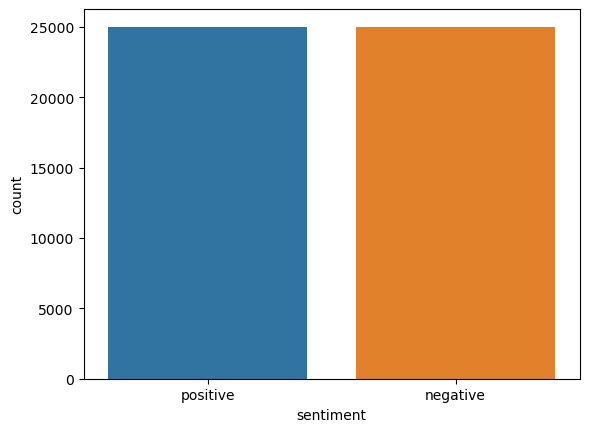

In [13]:
sns.countplot(cleaned_df, x = 'sentiment')

Balanced dataset between positive and negative reviews - this is good because don't need to do additional tuning or sampling to handle dataset imbalances

Vectorization methods in order to get numerical representations for the text
* bag of words
* tf-idf
* word2vec - word embeddings

for training and testing will follow an 80-20 split for training and testing respectively

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [15]:
X_train, X_test, y_train, y_test = train_test_split(cleaned_df['review_cleaned'], cleaned_df['sentiment'], test_size=0.2, random_state=42)

# Vectorization using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

model = LogisticRegression()
model.fit(X_train_vect, y_train)

y_pred = model.predict(X_test_vect) #predict

#get accuracy score
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

Accuracy: 0.8871
              precision    recall  f1-score   support

    negative       0.90      0.87      0.88      4961
    positive       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [16]:
def clean_single_review(review):
    review = remove_urls_html(review)
    review = remove_punctuation_numbers(review)
    review = lowercase(review)
    review = remove_stopwords(review)
    review = lemmatize(review)
    return review

In [19]:
#custom input
def test_model(review):
    cleaned = clean_single_review(review)
    new_review_vect = vectorizer.transform([cleaned])
    predicted_sentiment = model.predict(new_review_vect)
    return predicted_sentiment

In [ ]:
test_model("Hello how are you today?")

In [21]:
test_model("This is a great product!")

array(['positive'], dtype=object)

In [22]:
test_model("This product could be better")

array(['negative'], dtype=object)

---

In [23]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

In [27]:
from sklearn.model_selection import GridSearchCV
import joblib

In [28]:
def optimize_hyperparameters(X_train, y_train, classifier):
    if classifier == 'Logistic Regression':
        param_grid = {'C': [10**i for i in range(-8, 5)]}
        model = LogisticRegression(solver='liblinear')
    elif classifier == 'Naive Bayes':
        param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}
        model = MultinomialNB()
    else:
        pass #hyperparameters for other models is not defined yet, can add into if-else

    grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=3)
    grid_search.fit(X_train, y_train)

    return grid_search.best_params_

def evaluate_classifiers(X, y):
    results = []

    classifiers = ['Logistic Regression', 'Naive Bayes']
    splits = [0.2, 0.5, 0.8]

    best_accuracy = 0
    best_model = None
    best_model_name = ""

    for classifier in classifiers:
        for split in splits:
            train_accuracies = []
            test_accuracies = []
            validation_accuracies = []

            precisions = []
            recalls = []
            f1_scores = []

            for _ in range(3):  # 3 trials
                X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=1-split, random_state=None)
                X_test, X_validation, y_test, y_validation = train_test_split(X_temp, y_temp, test_size=split, random_state=None)

                vectorizer = TfidfVectorizer(max_features=5000)
                X_train_vect = vectorizer.fit_transform(X_train)
                X_test_vect = vectorizer.transform(X_test)
                X_validation_vect = vectorizer.transform(X_validation)

                hyperparams = optimize_hyperparameters(X_train_vect, y_train, classifier)

                if classifier == 'Logistic Regression':
                    model = LogisticRegression(solver='liblinear', **hyperparams)
                elif classifier == 'Naive Bayes':
                    model = MultinomialNB(alpha=hyperparams['alpha'])

                model.fit(X_train_vect, y_train)

                # Training accuracy
                train_pred = model.predict(X_train_vect)
                train_accuracies.append(accuracy_score(y_train, train_pred))

                # Test accuracy
                test_pred = model.predict(X_test_vect)
                test_accuracies.append(accuracy_score(y_test, test_pred))

                # Validation accuracy
                validation_pred = model.predict(X_validation_vect)
                validation_accuracies.append(accuracy_score(y_validation, validation_pred))

                # Precision, Recall, and F1 Score
                precisions.append(precision_score(y_validation, validation_pred, average='weighted'))
                recalls.append(recall_score(y_validation, validation_pred, average='weighted'))
                f1_scores.append(f1_score(y_validation, validation_pred, average='weighted'))

            # Calculate average metrics over trials
            avg_train_accuracy = sum(train_accuracies) / 3
            avg_test_accuracy = sum(test_accuracies) / 3
            avg_validation_accuracy = sum(validation_accuracies) / 3
            avg_precision = sum(precisions) / 3
            avg_recall = sum(recalls) / 3
            avg_f1_score = sum(f1_scores) / 3

            if avg_validation_accuracy > best_accuracy:
                best_accuracy = avg_validation_accuracy
                best_model = model
                best_model_name = classifier

            results.append({
                'Classifier': classifier,
                'Split': split,
                'Avg Train Accuracy': avg_train_accuracy,
                'Avg Test Accuracy': avg_test_accuracy,
                'Avg Validation Accuracy': avg_validation_accuracy,
                'Avg Precision': avg_precision,
                'Avg Recall': avg_recall,
                'Avg F1 Score': avg_f1_score,
                'Hyperparameters': hyperparams
            })

    # Save best model
    joblib.dump(best_model, f"best_model_{best_model_name}.joblib")

    return pd.DataFrame(results), best_model, vectorizer


# Evaluate classifiers and get the best model
evaluation_results, best_model, vectorizer = evaluate_classifiers(cleaned_df['review_cleaned'], cleaned_df['sentiment'])
print(evaluation_results)

            Classifier  Split  Avg Train Accuracy  Avg Test Accuracy  \
0  Logistic Regression    0.2            0.921100           0.871854   
1  Logistic Regression    0.5            0.912853           0.882613   
2  Logistic Regression    0.8            0.908817           0.891333   
3          Naive Bayes    0.2            0.880700           0.848927   
4          Naive Bayes    0.5            0.863853           0.851707   
5          Naive Bayes    0.8            0.860625           0.862333   

   Avg Validation Accuracy  Avg Precision  Avg Recall  Avg F1 Score  \
0                 0.871292       0.871951    0.871292      0.871248   
1                 0.883413       0.883762    0.883413      0.883388   
2                 0.889625       0.889799    0.889625      0.889617   
3                 0.850625       0.850676    0.850625      0.850625   
4                 0.850960       0.851207    0.850960      0.850937   
5                 0.855792       0.855901    0.855792      0.855785  

the model with best accuracy score happened to be Logistic Regression

In [31]:
#load the best model
model = joblib.load("best_model_Logistic Regression.joblib")  # or "best_model_Naive Bayes.joblib"

In [32]:
test_model('This was a decent product')

array(['positive'], dtype=object)

In [34]:
test_model('I have had other products that I think work better than this one')

array(['positive'], dtype=object)

In [38]:
test_model('not the best')

array(['negative'], dtype=object)

models often used for text classification:
* Logistic Regression
* Naive Bayes
* Support Vector Machines (SVM)
* Random Forest
* Neural Networks (e.g., LSTM, CNN)
* Transformers (e.g., BERT)

Future Work - using bigrams in order to create custom word vectorization model